In [12]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Class generate jobs

In [1]:
from src.ProfileGenerator import ProfileGenerator
from src.JobGenerator import JobGenerator

In [2]:
#Generate file

LOAD_FROM_FILE = False
MAX_RESOURCES = 4

prof_gen = ProfileGenerator(max_resources=MAX_RESOURCES)

if(LOAD_FROM_FILE):
    with open('profiles.json', 'r') as f:
        json_str = f.read()
        profiles = prof_gen.load_from_json(json_str)
else:
    profiles = prof_gen.generate(number_of_profiles=100, low_percent=0.6, med_percent=0.4, high_percent=0)

# Generate Jobs

In [3]:
import networkx as nx
import numpy as np

def linearly_increasing_probability(t):
    return t / 3600  # Aumenta linealmente hasta 1 en una

def cyclic_poisson_probability(t, base_lambda=0.05, amplitude=0.04, period=3600):
    # Variar lambda con una función sinusoidal
    lambda_t = base_lambda + amplitude * np.sin(2 * np.pi * t / period)
    
    # Probabilidad de 0 eventos en el intervalo de tiempo t usando el lambda variante
    prob_0 = np.exp(-lambda_t)
    
    # Probabilidad de al menos 1 evento en el intervalo de tiempo t
    return 1 - prob_0

base_graph = nx.DiGraph()
# Añadir nodos y aristas principales
base_graph.add_edge(0, 1)
base_graph.add_edge(1, 2)
base_graph.add_edge(2, 3)
base_graph.add_edge(3, 4)

# Añadir dependencias cruzadas
base_graph.add_edge(0, 2)  # Nodo 0 también influye en el nodo 2
base_graph.add_edge(1, 3)  # Nodo 1 también influye en el nodo 3
base_graph.add_edge(2, 4)  # Nodo 2 también influye en el nodo 4

# Añadir nodos y aristas adicionales para mayor complejidad
base_graph.add_edge(0, 5)
base_graph.add_edge(5, 6)
base_graph.add_edge(6, 4)  # Nodo 6 influye en el nodo 4
base_graph.add_edge(3, 6)  # Nodo 3 también influye en el nodo 6

job_gen = JobGenerator(profiles)
# revisa el batch cada 1 hora, por 3 días
job_gen.generate_variable_dag(cyclic_poisson_probability, base_graph, check_interval=40, duration=259200)

In [17]:
import networkx as nx
A = nx.nx_agraph.to_agraph(base_graph)
A.layout(prog='dot')
A.draw('temp.png')  # Save the visualization in a temporary file

In [6]:
job_gen.generate_jobs_dataframe()

,id,profile,res,subtime,walltime,dependencies
0,0,med_87,1,320,94.762657,None
1,1,low_4,1,320,10.266023,0
2,2,low_53,1,320,7.490191,"0, 1"
3,3,med_98,1,320,82.526556,"1, 2"
4,4,med_80,1,320,37.459119,"2, 3, 6"
...,...,...,...,...,...,...
1983,1983,low_8,1,257000,9.559640,"1981, 1982"
1984,1984,med_67,1,257000,27.039605,"1982, 1983"
1985,1985,low_49,1,257000,19.437584,"1983, 1984, 1987"
1986,1986,low_39,1,257000,8.334883,1981


In [10]:
job_gen.generate_jobs_json('workload')

/home/jpbrione/.conda/envs/bati-env/lib/python3.12/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: neato: graph is too large for cairo-renderer bitmaps. Scaling by 0.143936 to fit

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


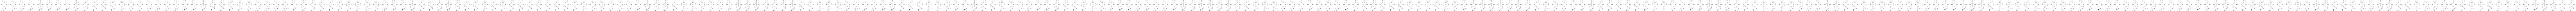

In [11]:
job_gen.visualize_with_subtime_annotations_dot()

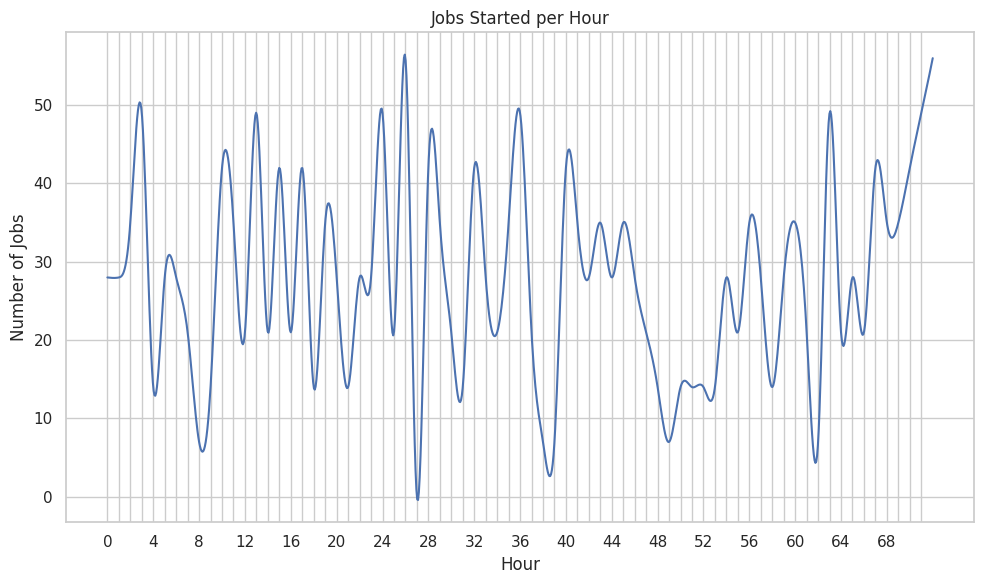

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from scipy.interpolate import CubicSpline

def plot_jobs_per_hour(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        
    # Extrayendo información de los trabajos
    jobs = data['jobs']
    start_times = [job['subtime'] for job in jobs]
    
    # Convertir segundos a horas
    start_times_in_hours = [time / 3600 for time in start_times]
    
    # Determinar el rango de horas
    min_hour = int(min(start_times_in_hours))
    max_hour = int(max(start_times_in_hours)) + 1  # +1 para incluir la última hora
    
    # Creando histograma
    bins = np.arange(min_hour, max_hour + 1)  # +1 para el límite final
    hist, bin_edges = np.histogram(start_times_in_hours, bins=bins)
    
    # Configuración de Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Interpolación spline cúbica para suavizar la curva
    cs = CubicSpline(bin_edges[:-1], hist, bc_type='natural')
    xs = np.linspace(min_hour, max_hour, 1000)
    
    # Dibujar la curva suavizada
    sns.lineplot(x=xs, y=cs(xs), color='b')
    
    # Configurar las marcas del eje x para que aparezcan en cada hora
    plt.xticks(bin_edges[:-1])
    # Configurar las etiquetas del eje x para que se muestren cada 4 horas
    plt.gca().set_xticklabels([f"{int(i)}" if i % 4 == 0 else "" for i in bin_edges[:-1]])
    
    plt.xlabel('Hour')
    plt.ylabel('Number of Jobs')
    plt.title('Jobs Started per Hour')
    
    plt.tight_layout()
    plt.savefig('jobsxhour.png')
    plt.show()

# Usar la función para mostrar el gráfico por hora
plot_jobs_per_hour('workload.json')

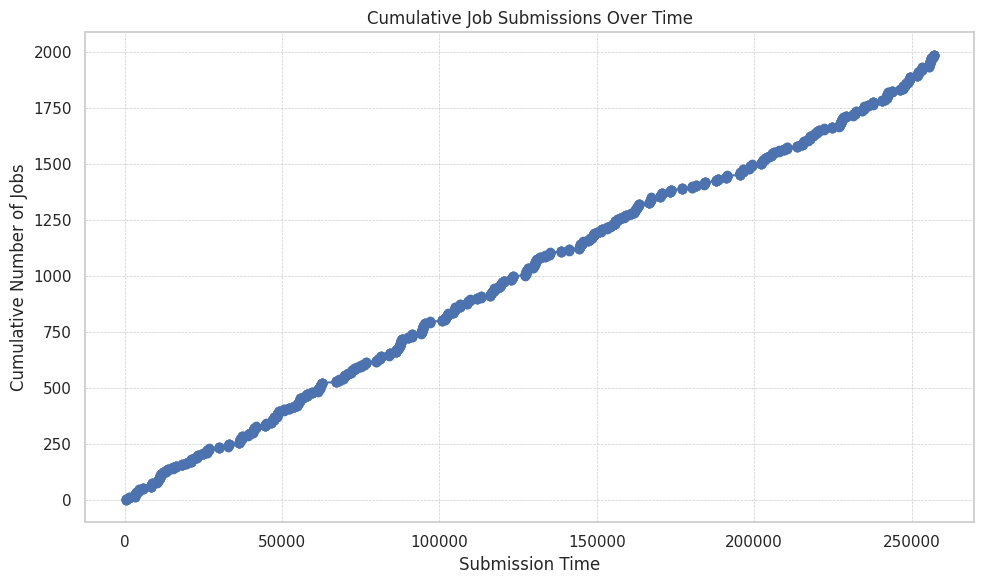

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Load the generated jobs from the JSON
with open("workload.json", "r") as file:
    workload_data = json.load(file)

# Extract subtimes
subtimes = [job["subtime"] for job in workload_data["jobs"]]

# Sorting subtimes
sorted_subtimes = np.sort(subtimes)

# Create a cumulative count of jobs for each unique subtime
cumulative_counts = np.arange(1, len(sorted_subtimes) + 1)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_subtimes, cumulative_counts, marker='o', linestyle='-', color='b')
plt.title("Cumulative Job Submissions Over Time")
plt.xlabel("Submission Time")
plt.ylabel("Cumulative Number of Jobs")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [13]:
!cp workload.json ../../workloads/
!cp workload_dependencies.json ../../workloads/